## 1. Introdução

### **Sessão e leitura dos dados**

In [109]:
# Instalando o PySpark
!pip install pyspark

In [110]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
          .master('local[*]') \
          .appName('analise_nlp') \
          .getOrCreate()

In [111]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive #2. Pelo carregamento no colab.(<---)
dados = spark.read.csv("/content/imdb-reviews-pt-br.csv",
                       escape = '\"',
                       inferSchema = True,
                       header = True
                       )

### **Explorando os dados**



In [112]:
...# O tamanho dos dados
print(f"Nº de Linhas: {dados.count()}", f"| Nº de colunas:{len(dados.columns)}")

Nº de Linhas: 49459 | Nº de colunas:4


In [113]:
# campos e tipos
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [114]:
# conteudo
dados.limit(99).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [115]:
# Apresentando alguns comentarios  ditos como negativos ou positivos
print("Comentario Negativo")
dados.filter(dados.id == 190).select("text_pt").show(truncate = False)

print("Comentario Postivo") #final da base de dados são mais de cometarios positivos
dados.filter(dados.id == 12427).select("text_pt").show(truncate = False)

Comentario Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                      

In [116]:
# Contabilizando os tipos de comentarios
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



## 2. Limpeza e processamento

In [117]:
# Lembrando como estão nossos dados
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



### WordCloud

Recurso para entender as palavras mais frequentes.

In [118]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [119]:
amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [120]:
wordcloud = WordCloud(
    collocations = False,
    background_color='white',
    prefer_horizontal=1,
    width = 1000,
    height=600
).generate(str(tudo))

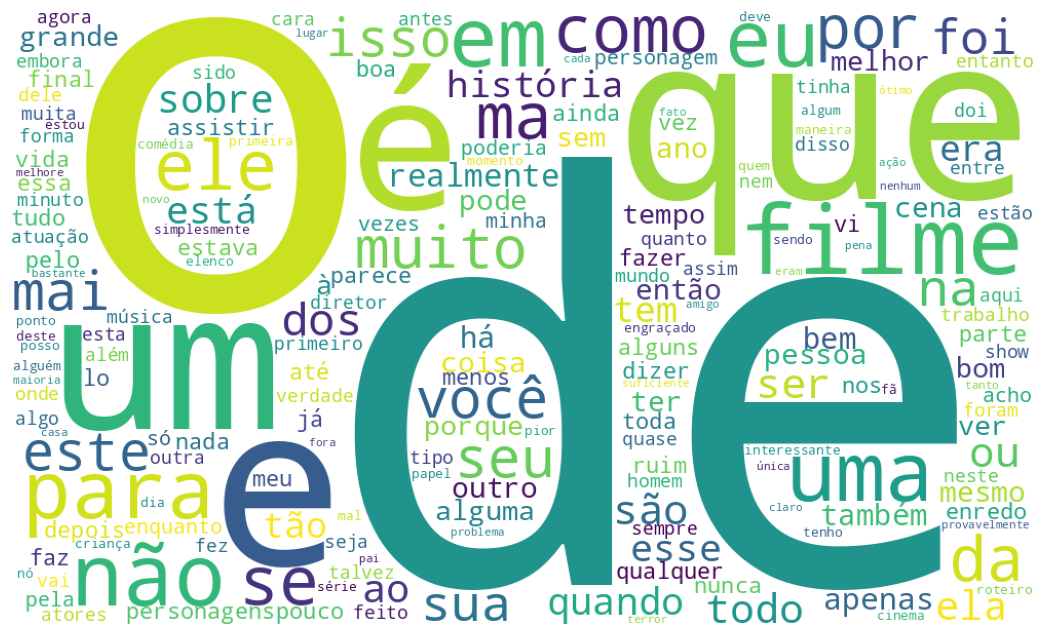

In [121]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#Poucas palavras que dão sentido

### Caractere especial

In [122]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [123]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])

In [124]:
import pyspark.sql.functions as f

In [125]:
amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))
amostra.show(truncate = False)

+------------------------------------------+------------------------------+
|textos                                    |texto_regex                   |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



In [126]:
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))
amostra.show(truncate = False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regex                   |texto_limpo                  |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

In [127]:
#1. retirando os caracteres especiais dos dados
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))


### Tokenização

In [128]:
#3. tokenizando os dados
from pyspark.ml.feature import Tokenizer

In [129]:
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
tokenizado = tokenizer.transform(dados)

In [130]:
tokenizado.select("texto_limpo", "tokens").show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [131]:
# Entendendo em quantos tokens os comentários foram divididos
from pyspark.sql.types import IntegerType
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo", "tokens")\
          .withColumn("freq_token", countTokens(f.col("tokens")))\
          .show()

+--------------------+--------------------+----------+
|         texto_limpo|              tokens|freq_token|
+--------------------+--------------------+----------+
|Once again Mr Cos...|[once, again, mr,...|       168|
|This is an exampl...|[this, is, an, ex...|       232|
|First of all I ha...|[first, of, all, ...|       215|
|Not even the Beat...|[not, even, the, ...|       308|
|Brass pictures mo...|[brass, pictures,...|       238|
|A funny thing hap...|[a, funny, thing,...|       115|
|This German horro...|[this, german, ho...|       156|
|Being a longtime ...|[being, a, longti...|       136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|       129|
|Wealthy horse ran...|[wealthy, horse, ...|       160|
|Cage plays a drun...|[cage, plays, a, ...|       109|
|First of all I wo...|[first, of, all, ...|       333|
|So tell me  what ...|[so, tell, me, , ...|       243|
|A big disappointm...|[a, big, disappoi...|       110|
|This film is abso...|[this, film, is, ...|       185|
|Heres a d

### StopWords

remoção de ruídos

In [132]:
#Exemplo pequeno
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
                (0, 'Spark MLlib não ajuda muito'),
                (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [133]:
# Explorando biblioteca nltk
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [134]:
from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")

In [135]:
stop_A

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [136]:
#Explorando bilbioteca ndo pyspark
from pyspark.ml.feature import StopWordsRemover

In [137]:
stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [138]:
stop_B

['de',
 'a',
 'o',
 'que',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera',
 'es

In [139]:
from pyspark.ml.feature import Tokenizer

In [140]:
tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
tokenized = tokenizer.transform(df)

In [141]:
remover = StopWordsRemover(inputCol="tokens", outputCol="texto_final", stopWords=stop_A)
df = remover.transform(tokenized)

In [142]:
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [143]:
remover = StopWordsRemover(inputCol="tokens", outputCol="texto_final", stopWords=stop_B)
df = remover.transform(tokenized)

In [144]:
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [145]:
#Retirando os stopwords dos depoimentos
remover = StopWordsRemover(inputCol="tokens", outputCol="texto_final", stopWords=stop_B)
feature_data = remover.transform(tokenizado)

In [146]:
feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[once, again, mr,...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[this, is, an, ex...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, of, all, ...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[not, even, the, ...|
|  5|B

In [147]:
#Contagem de tokens antes e depois do stopwords.
feature_data.select("tokens", "texto_final")\
      .withColumn("freq_tokens", countTokens(f.col("tokens")))\
      .withColumn("freq_tokens_limpos", countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|freq_tokens|freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[once, again, mr,...|[once, again, mr,...|        168|               159|
|[this, is, an, ex...|[this, is, an, ex...|        232|               225|
|[first, of, all, ...|[first, of, all, ...|        215|               203|
|[not, even, the, ...|[not, even, the, ...|        308|               295|
|[brass, pictures,...|[brass, pictures,...|        238|               230|
|[a, funny, thing,...|[funny, thing, ha...|        115|               110|
|[this, german, ho...|[this, german, ho...|        156|               149|
|[being, a, longti...|[being, longtime,...|        136|               130|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|               115|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|               151|
|[cage, plays, a, ...|[ca

##3. Vetorização das palavras

### Bag of words

identifica palavras mais reconrrentes

In [148]:
#retomando nosso exemplo
from pyspark.ml.feature import CountVectorizer

In [149]:
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")

In [150]:
model = cv.fit(df)
df = model.transform(df)

In [151]:
df.select("texto_final", "CountVec").show(truncate=False)

+---------------------------------------+-------------------------------------+
|texto_final                            |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,3,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,2,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



In [152]:
# Quais são as palavras
model.vocabulary

['spark', 'é', 'mllib', 'fácil', 'ajuda', 'nlp', 'ótimo']

In [153]:
# CountVector

from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(feature_data)
CountVectorizer_features = model.transform(feature_data)

CountVectorizer_features.select("texto_final", "CountVec").limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Hashing TF

Alternativa para o CountVector

In [154]:
from pyspark.ml.feature import HashingTF

In [155]:
hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HashingTF_cec117560833

In [156]:
HTFfeaturizedData = hashingTF.transform(CountVectorizer_features)

In [157]:
HTFfeaturizedData.select("texto_final","hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[once, again, mr,...|(50,[0,2,4,5,6,7,...|
|[this, is, an, ex...|(50,[0,1,2,3,4,5,...|
|[first, of, all, ...|(50,[0,1,2,3,5,6,...|
|[not, even, the, ...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



###TF-IDF

In [158]:
from pyspark.ml.feature import IDF

In [159]:
idf = IDF(inputCol="hashingTF", outputCol="features")

idfModel = idf.fit(HTFfeaturizedData)

TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [160]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

###Pipeline de Transformação

In [161]:
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [162]:
# Codificando a variável resposta.
# 1. replace
# 2. stringindexer (sentiment -> label)

from pyspark.ml.feature import StringIndexer

In [163]:

stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")

dados = stringindexer.fit(dados).transform(dados)

In [164]:
# Quem é 0 e quem é 1?
dados.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [165]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])


In [166]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [167]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

##4 . Treinando o modelo

###Árvore de Decisão

In [169]:
featureDF = dados_transformados.select(['features', 'label'])

In [171]:
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [172]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [175]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")

stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")

hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)

tfidf = IDF(inputCol="HTF", outputCol="features")

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf, dt])

##Amostra e Treino

In [177]:
#separando nossos dados
train, test = dados.randomSplit([0.7, 0.3], seed=101)

In [178]:
# ajustando o modelo com a pipeline
dt_model = pipeline.fit(train)

In [179]:
# aplicando na base teste
predictions = dt_model.transform(test)

In [180]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...| [366.0,1112.0]|[0.24763193504736...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

In [181]:
##5 . Explicando os resultados

###Teste e métricas

In [183]:
predictions.select(['label', 'prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [187]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

acuracia = evaluator.evaluate(predictions)

In [189]:
print("Acuracia = %s", (acuracia))

Acuracia = %s 0.6700404858299596


In [192]:
###Nova frase

In [194]:
nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "texto_limpo"])

In [197]:
nova_classe = dt_model.transform(nova_base)

In [198]:
nova_classe.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|  [18.0,10.0]|[0.64285714285714...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[156.0,774.0]|[0.16774193548387...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+

